In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from umap import UMAP


# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
file_paths = [
    "../data/fft_data/2025-11-11_07-38-32(kim,rubbing,new device).csv",
    "../data/fft_data/2025-11-11_07-41-44(kim,crumple,new device).csv",
    "../data/fft_data/2025-11-11_07-46-25(shin,rubbing,new device).csv",
    "../data/fft_data/2025-11-11_10-58-11(shin,crumple,new device).csv",
    "../data/fft_data/2025-11-11_11-04-25(shin,idle, new deivce).csv",
    "../data/fft_data/2025-11-12_05-24-36(jung,rubbing,new device).csv",
    "../data/fft_data/2025-11-12_05-27-27(jung,crumple,new device).csv"
]
bands = {
    "Low (1–10)": (0, 11),
    "Mid (11–20)": (11, 21),
    "High (21–31)": (21, 32),
}

In [59]:
def extract_label(path):
    name = os.path.basename(path)
    for label in ["rubbing", "crumple", "idle"]:
        if label in name:
            return label
    return "unknown"
def get_freq_band(df, start, end):
    mic1_cols = df.filter(like='mic1_').columns[start:end]
    mic2_cols = df.filter(like='mic2_').columns[start:end]
    # mic1 = df[mic1_cols]
    # mic2 = df[mic2_cols]
    # return mic1, mic2
    return mic1_cols, mic2_cols

In [60]:
dfs = []
for path in file_paths:
    df = pd.read_csv(path)
    df["label"] = extract_label(path)
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

In [61]:
data.head()

,timestamp,mic1_0,mic1_1,mic1_2,mic1_3,mic1_4,mic1_5,mic1_6,mic1_7,mic1_8,...,mic2_23,mic2_24,mic2_25,mic2_26,mic2_27,mic2_28,mic2_29,mic2_30,mic2_31,label
0,1762846712042,34325,602,357,214,141,106,61,50,57,...,24,59,51,54,18,21,23,22,28,rubbing
1,1762846712042,33968,200,120,54,94,103,101,98,103,...,31,47,29,57,45,49,47,48,44,rubbing
2,1762846712049,33186,35,38,27,27,26,18,37,63,...,5,7,4,4,3,2,8,8,1,rubbing
3,1762846712049,33752,530,354,152,64,135,127,62,61,...,35,30,20,33,35,14,37,51,40,rubbing
4,1762846712049,33211,349,296,215,170,80,18,8,63,...,37,36,27,28,47,31,35,85,17,rubbing


In [62]:
data.describe().astype(int).loc["mean"]

timestamp    1762872720336
mic1_0               33432
mic1_1                3916
mic1_2                2109
mic1_3                1486
                 ...      
mic2_27                123
mic2_28                118
mic2_29                116
mic2_30                122
mic2_31                115
Name: mean, Length: 65, dtype: int64

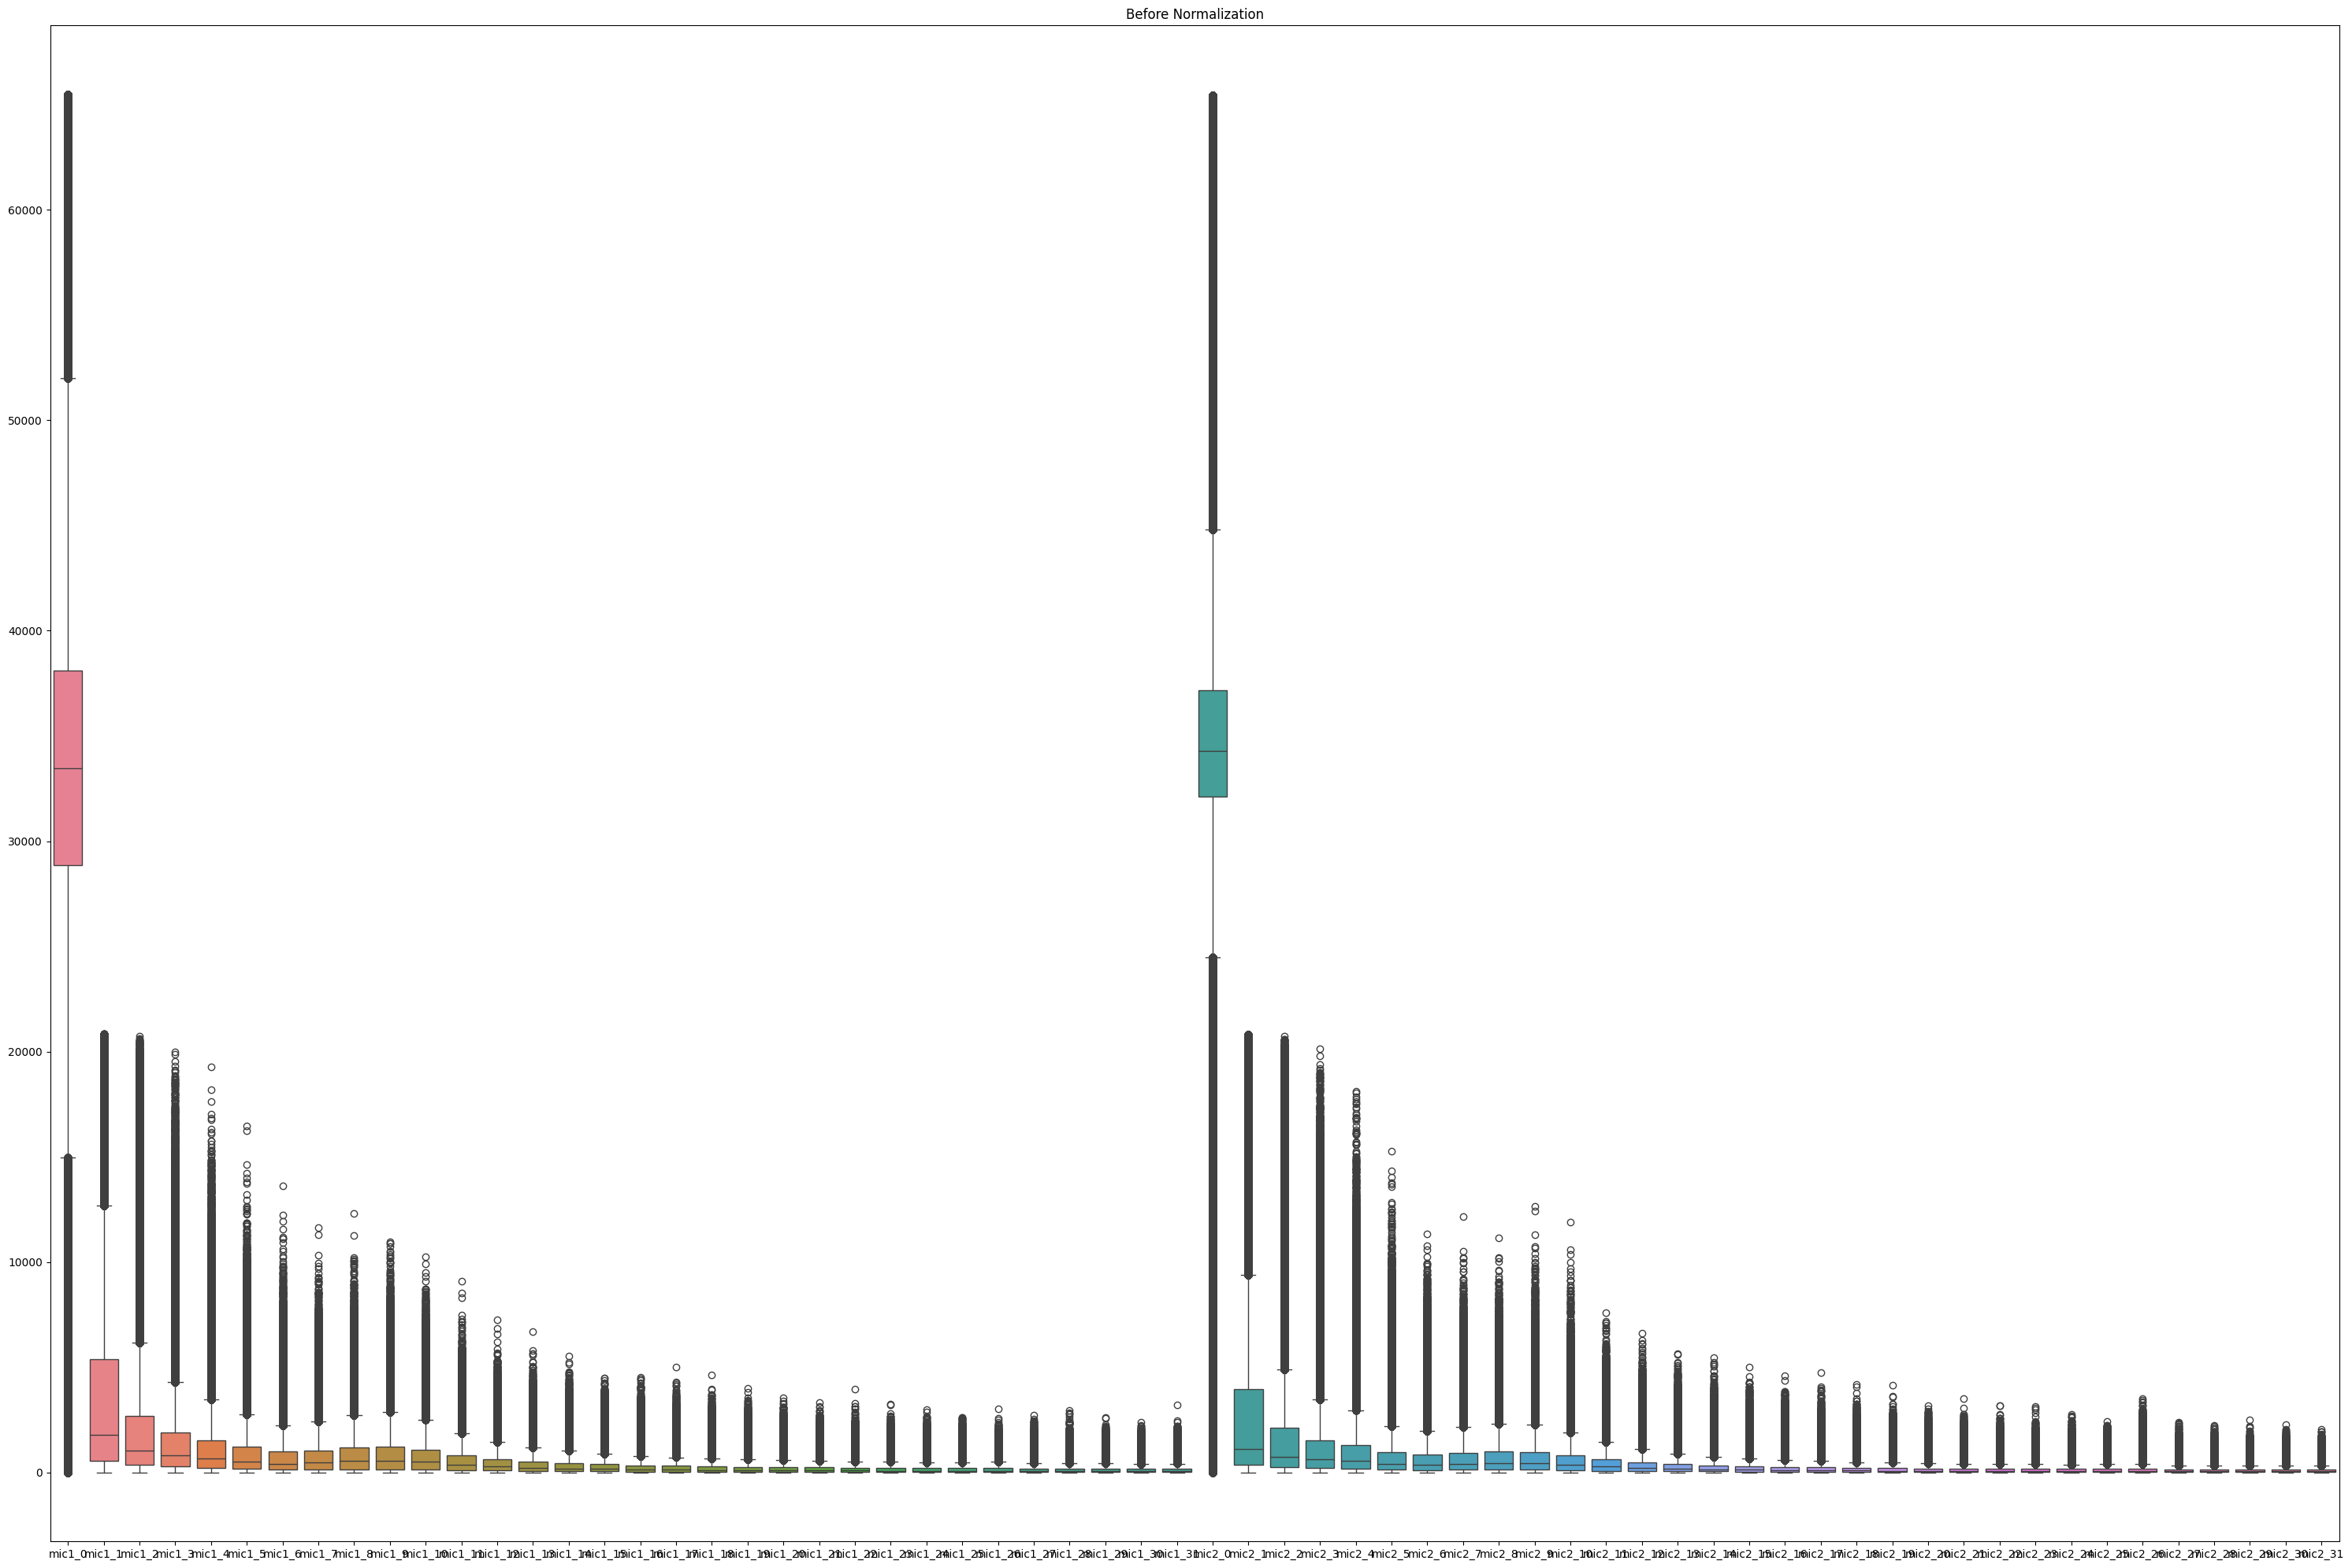

In [63]:
plt.figure(figsize=(30, 20))
sns.boxplot(data=data[fft_cols])
plt.title("Before Normalization")
plt.tight_layout()
plt.show()

In [76]:
fft_cols = [c for c in data.columns if "mic" in c]

data_scaled = data.drop(columns=["timestamp", "label"]).values

data_log_scaled = np.log1p(data_scaled)
mean = data_log_scaled.mean(axis=0)
std = data_log_scaled.std(axis=0, ddof=0)
# # ddof = 0, 샘플로부터 모집단을 추정하기 위해서이다.
data_log_scaled = (data_log_scaled - mean) / std
data_log_scaled = pd.DataFrame(data_log_scaled, columns=fft_cols)
# data_log_scaled = pd.concat([data["timestamp"], data_log_scaled, data["label"]], axis=1)

In [77]:
data_log_scaled.describe()

,mic1_0,mic1_1,mic1_2,mic1_3,mic1_4,mic1_5,mic1_6,mic1_7,mic1_8,mic1_9,...,mic2_22,mic2_23,mic2_24,mic2_25,mic2_26,mic2_27,mic2_28,mic2_29,mic2_30,mic2_31
count,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,...,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05
mean,1.698517e-15,-1.496857e-16,-4.989525e-17,-9.979049e-17,-9.979049e-17,-4.989525e-16,1.746334e-16,5.322160e-16,-1.330540e-16,1.164222e-16,...,1.496857e-16,-1.330540e-16,1.496857e-16,1.829492e-16,8.315874e-17,3.492667e-16,-2.827397e-16,-8.315874e-17,3.825302e-16,1.995810e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.450411e+01,-4.282621e+00,-4.198314e+00,-4.245732e+00,-4.248180e+00,-4.595417e+00,-4.228761e+00,-3.763720e+00,-3.678670e+00,-3.599387e+00,...,-3.081569e+00,-3.108236e+00,-3.166689e+00,-3.124046e+00,-3.045547e+00,-2.971643e+00,-2.944132e+00,-2.991673e+00,-3.271215e+00,-2.972579e+00
25%,-4.984723e-02,-5.928685e-01,-5.605744e-01,-5.710194e-01,-6.060059e-01,-6.644637e-01,-6.103940e-01,-5.748678e-01,-5.496853e-01,-5.528393e-01,...,-6.874989e-01,-6.876973e-01,-6.964454e-01,-7.078988e-01,-7.153740e-01,-7.158527e-01,-7.212242e-01,-7.354826e-01,-6.729354e-01,-7.241554e-01
50%,1.585978e-01,1.109574e-01,1.178632e-01,1.320516e-01,1.408640e-01,8.191686e-02,1.000060e-01,2.041161e-01,2.427006e-01,2.564975e-01,...,6.095254e-02,5.863807e-02,3.248311e-02,3.207327e-02,3.736533e-02,1.087727e-02,1.923228e-03,-1.507672e-03,7.140829e-03,-7.003652e-03
75%,3.417432e-01,7.540026e-01,7.088993e-01,6.972927e-01,7.109237e-01,7.162488e-01,7.219370e-01,7.312589e-01,7.335719e-01,7.332803e-01,...,7.051025e-01,7.073043e-01,7.091491e-01,7.265498e-01,7.454908e-01,7.309620e-01,7.332147e-01,7.246515e-01,7.139814e-01,7.309522e-01
max,1.104020e+00,1.545939e+00,1.982585e+00,2.245345e+00,2.432051e+00,2.664537e+00,2.610035e+00,2.286394e+00,2.195752e+00,2.063890e+00,...,2.841135e+00,2.868361e+00,2.842329e+00,2.726581e+00,2.938853e+00,2.789635e+00,2.778361e+00,2.899985e+00,2.895924e+00,2.747082e+00


In [78]:
X_scaled_df.describe()

,mic1_0,mic1_1,mic1_2,mic1_3,mic1_4,mic1_5,mic1_6,mic1_7,mic1_8,mic1_9,...,mic2_22,mic2_23,mic2_24,mic2_25,mic2_26,mic2_27,mic2_28,mic2_29,mic2_30,mic2_31
count,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,...,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05,4.374740e+05
mean,1.698517e-15,-1.496857e-16,-4.989525e-17,-9.979049e-17,-9.979049e-17,-4.989525e-16,1.746334e-16,5.322160e-16,-1.330540e-16,1.164222e-16,...,1.496857e-16,-1.330540e-16,1.496857e-16,1.829492e-16,8.315874e-17,3.492667e-16,-2.827397e-16,-8.315874e-17,3.825302e-16,1.995810e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.450411e+01,-4.282621e+00,-4.198314e+00,-4.245732e+00,-4.248180e+00,-4.595417e+00,-4.228761e+00,-3.763720e+00,-3.678670e+00,-3.599387e+00,...,-3.081569e+00,-3.108236e+00,-3.166689e+00,-3.124046e+00,-3.045547e+00,-2.971643e+00,-2.944132e+00,-2.991673e+00,-3.271215e+00,-2.972579e+00
25%,-4.984723e-02,-5.928685e-01,-5.605744e-01,-5.710194e-01,-6.060059e-01,-6.644637e-01,-6.103940e-01,-5.748678e-01,-5.496853e-01,-5.528393e-01,...,-6.874989e-01,-6.876973e-01,-6.964454e-01,-7.078988e-01,-7.153740e-01,-7.158527e-01,-7.212242e-01,-7.354826e-01,-6.729354e-01,-7.241554e-01
50%,1.585978e-01,1.109574e-01,1.178632e-01,1.320516e-01,1.408640e-01,8.191686e-02,1.000060e-01,2.041161e-01,2.427006e-01,2.564975e-01,...,6.095254e-02,5.863807e-02,3.248311e-02,3.207327e-02,3.736533e-02,1.087727e-02,1.923228e-03,-1.507672e-03,7.140829e-03,-7.003652e-03
75%,3.417432e-01,7.540026e-01,7.088993e-01,6.972927e-01,7.109237e-01,7.162488e-01,7.219370e-01,7.312589e-01,7.335719e-01,7.332803e-01,...,7.051025e-01,7.073043e-01,7.091491e-01,7.265498e-01,7.454908e-01,7.309620e-01,7.332147e-01,7.246515e-01,7.139814e-01,7.309522e-01
max,1.104020e+00,1.545939e+00,1.982585e+00,2.245345e+00,2.432051e+00,2.664537e+00,2.610035e+00,2.286394e+00,2.195752e+00,2.063890e+00,...,2.841135e+00,2.868361e+00,2.842329e+00,2.726581e+00,2.938853e+00,2.789635e+00,2.778361e+00,2.899985e+00,2.895924e+00,2.747082e+00


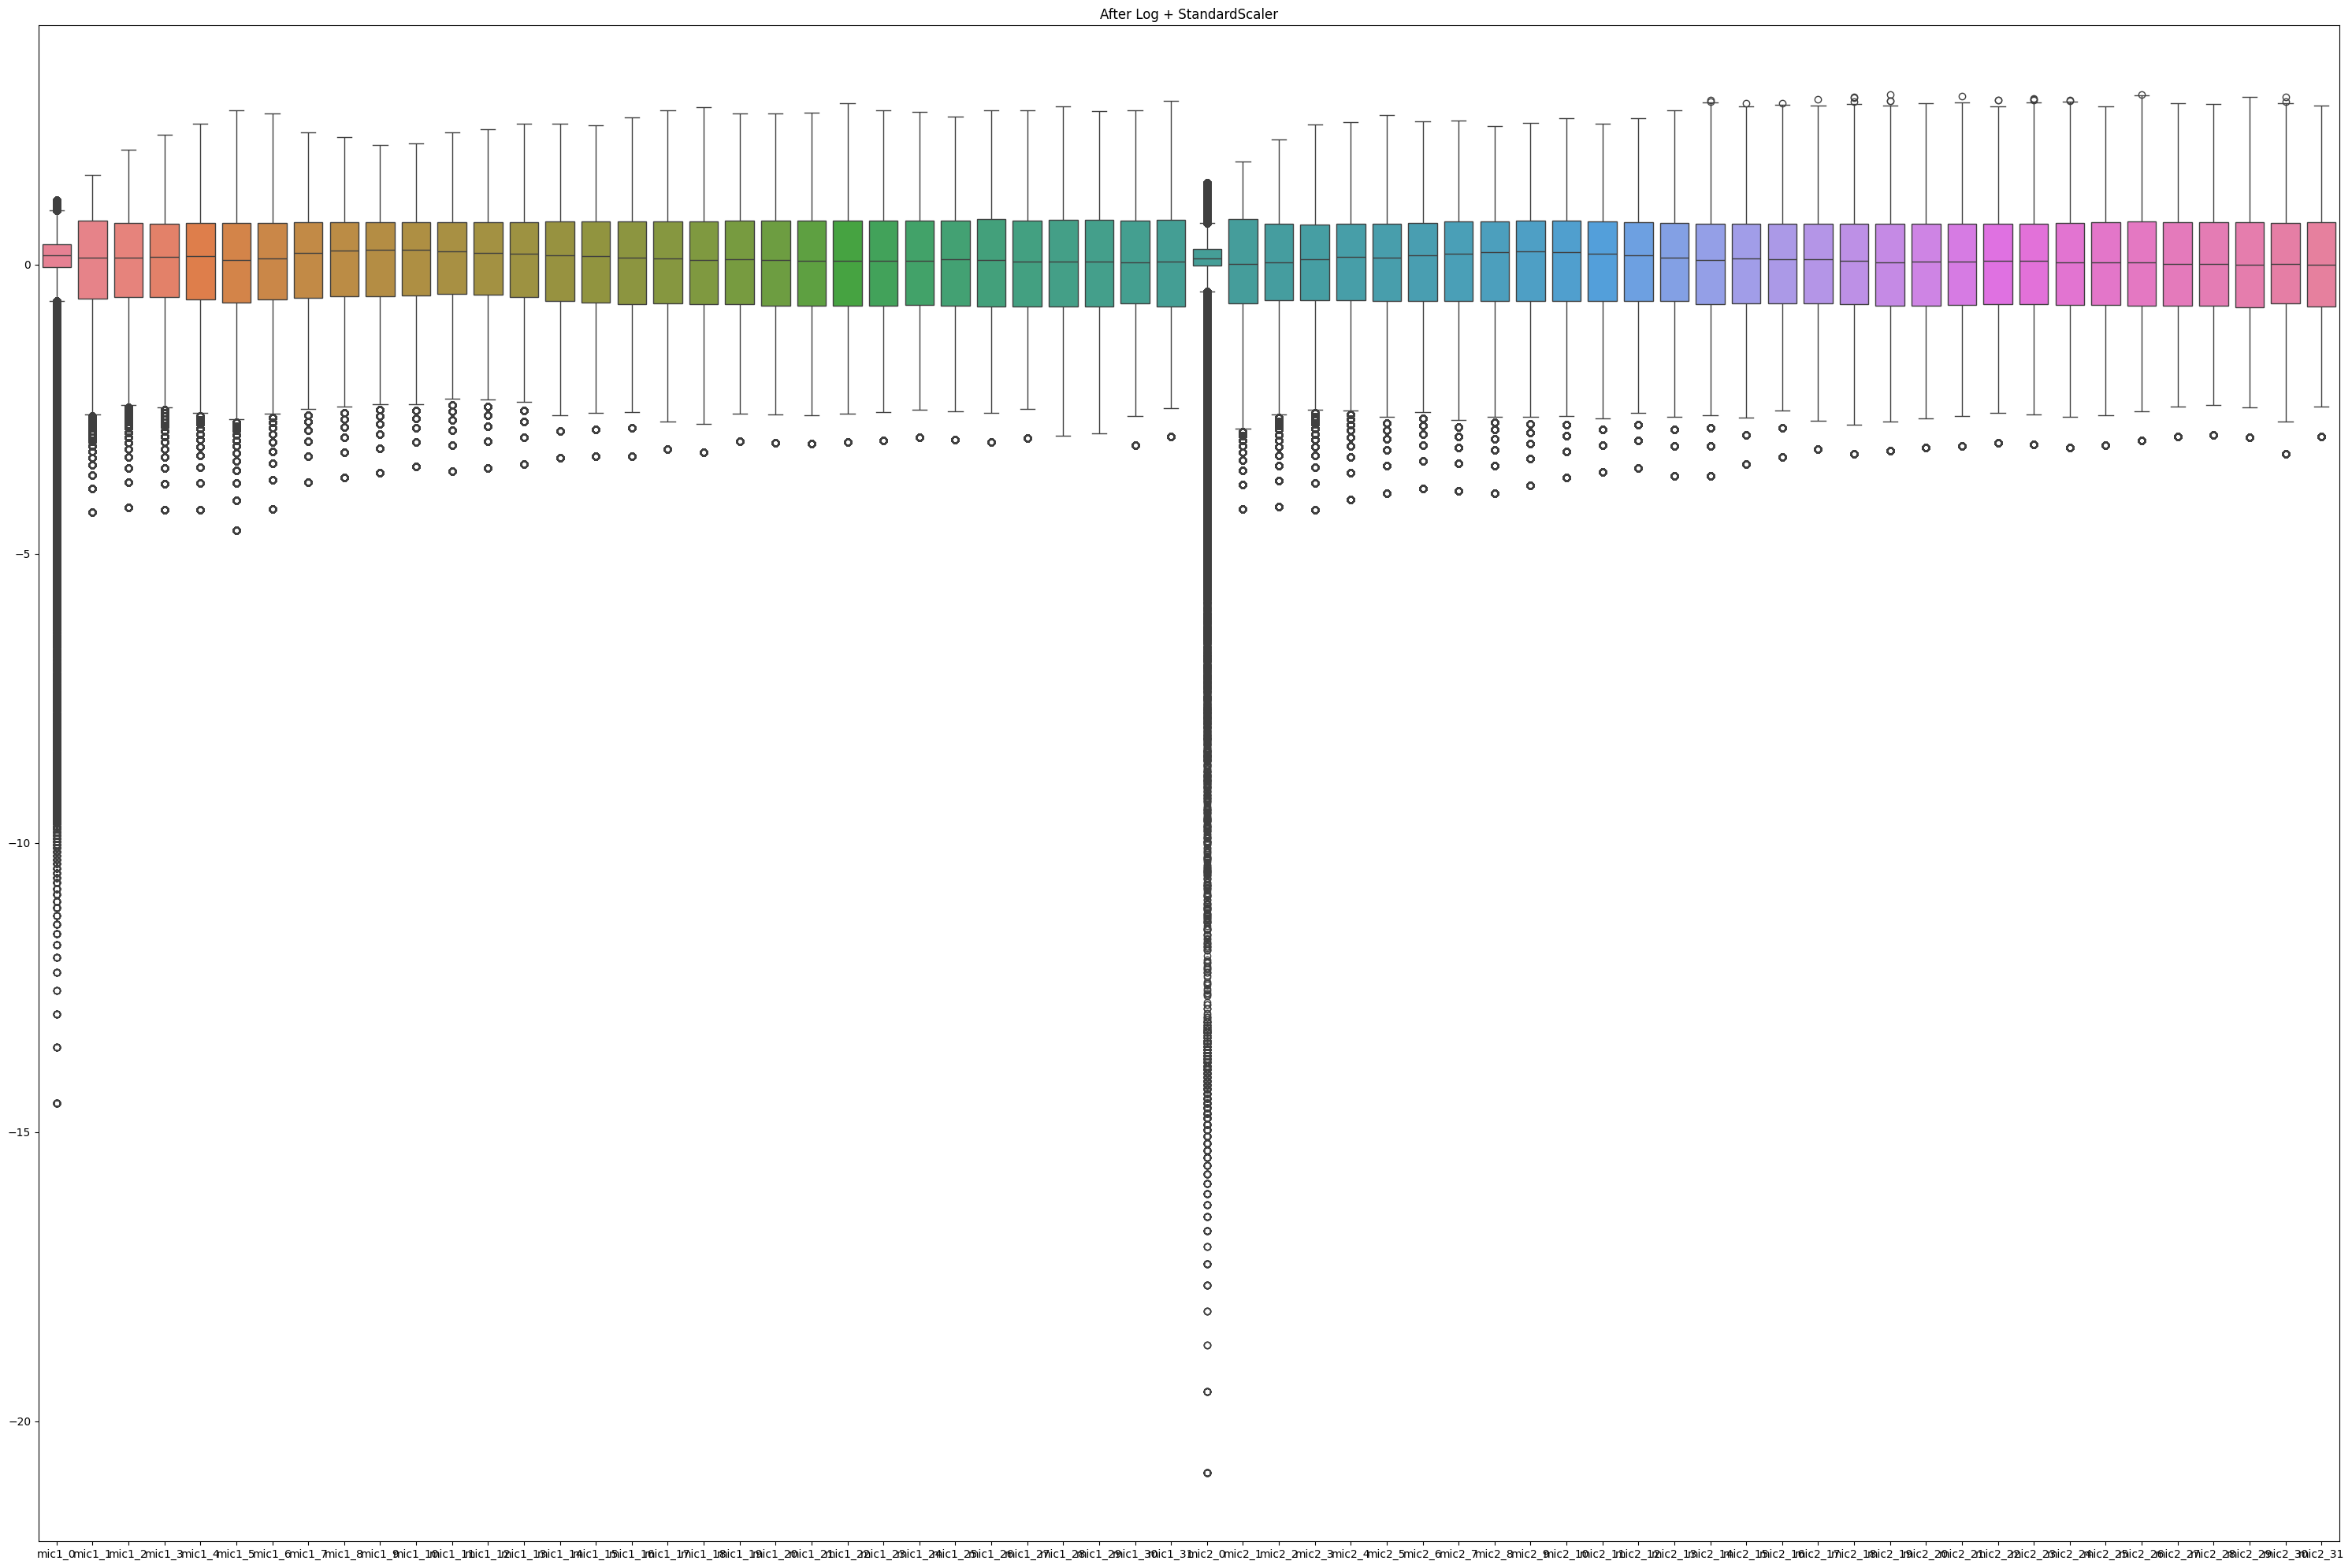

In [79]:
plt.figure(figsize=(30, 20))
sns.boxplot(data=data_log_scaled)
plt.title("After Log + StandardScaler")
plt.tight_layout()
plt.show()

In [74]:
fft_cols = [c for c in data.columns if "mic" in c]
X = data[fft_cols].values
X_log = np.log1p(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)
X_scaled_df = pd.DataFrame(X_scaled, columns=fft_cols)


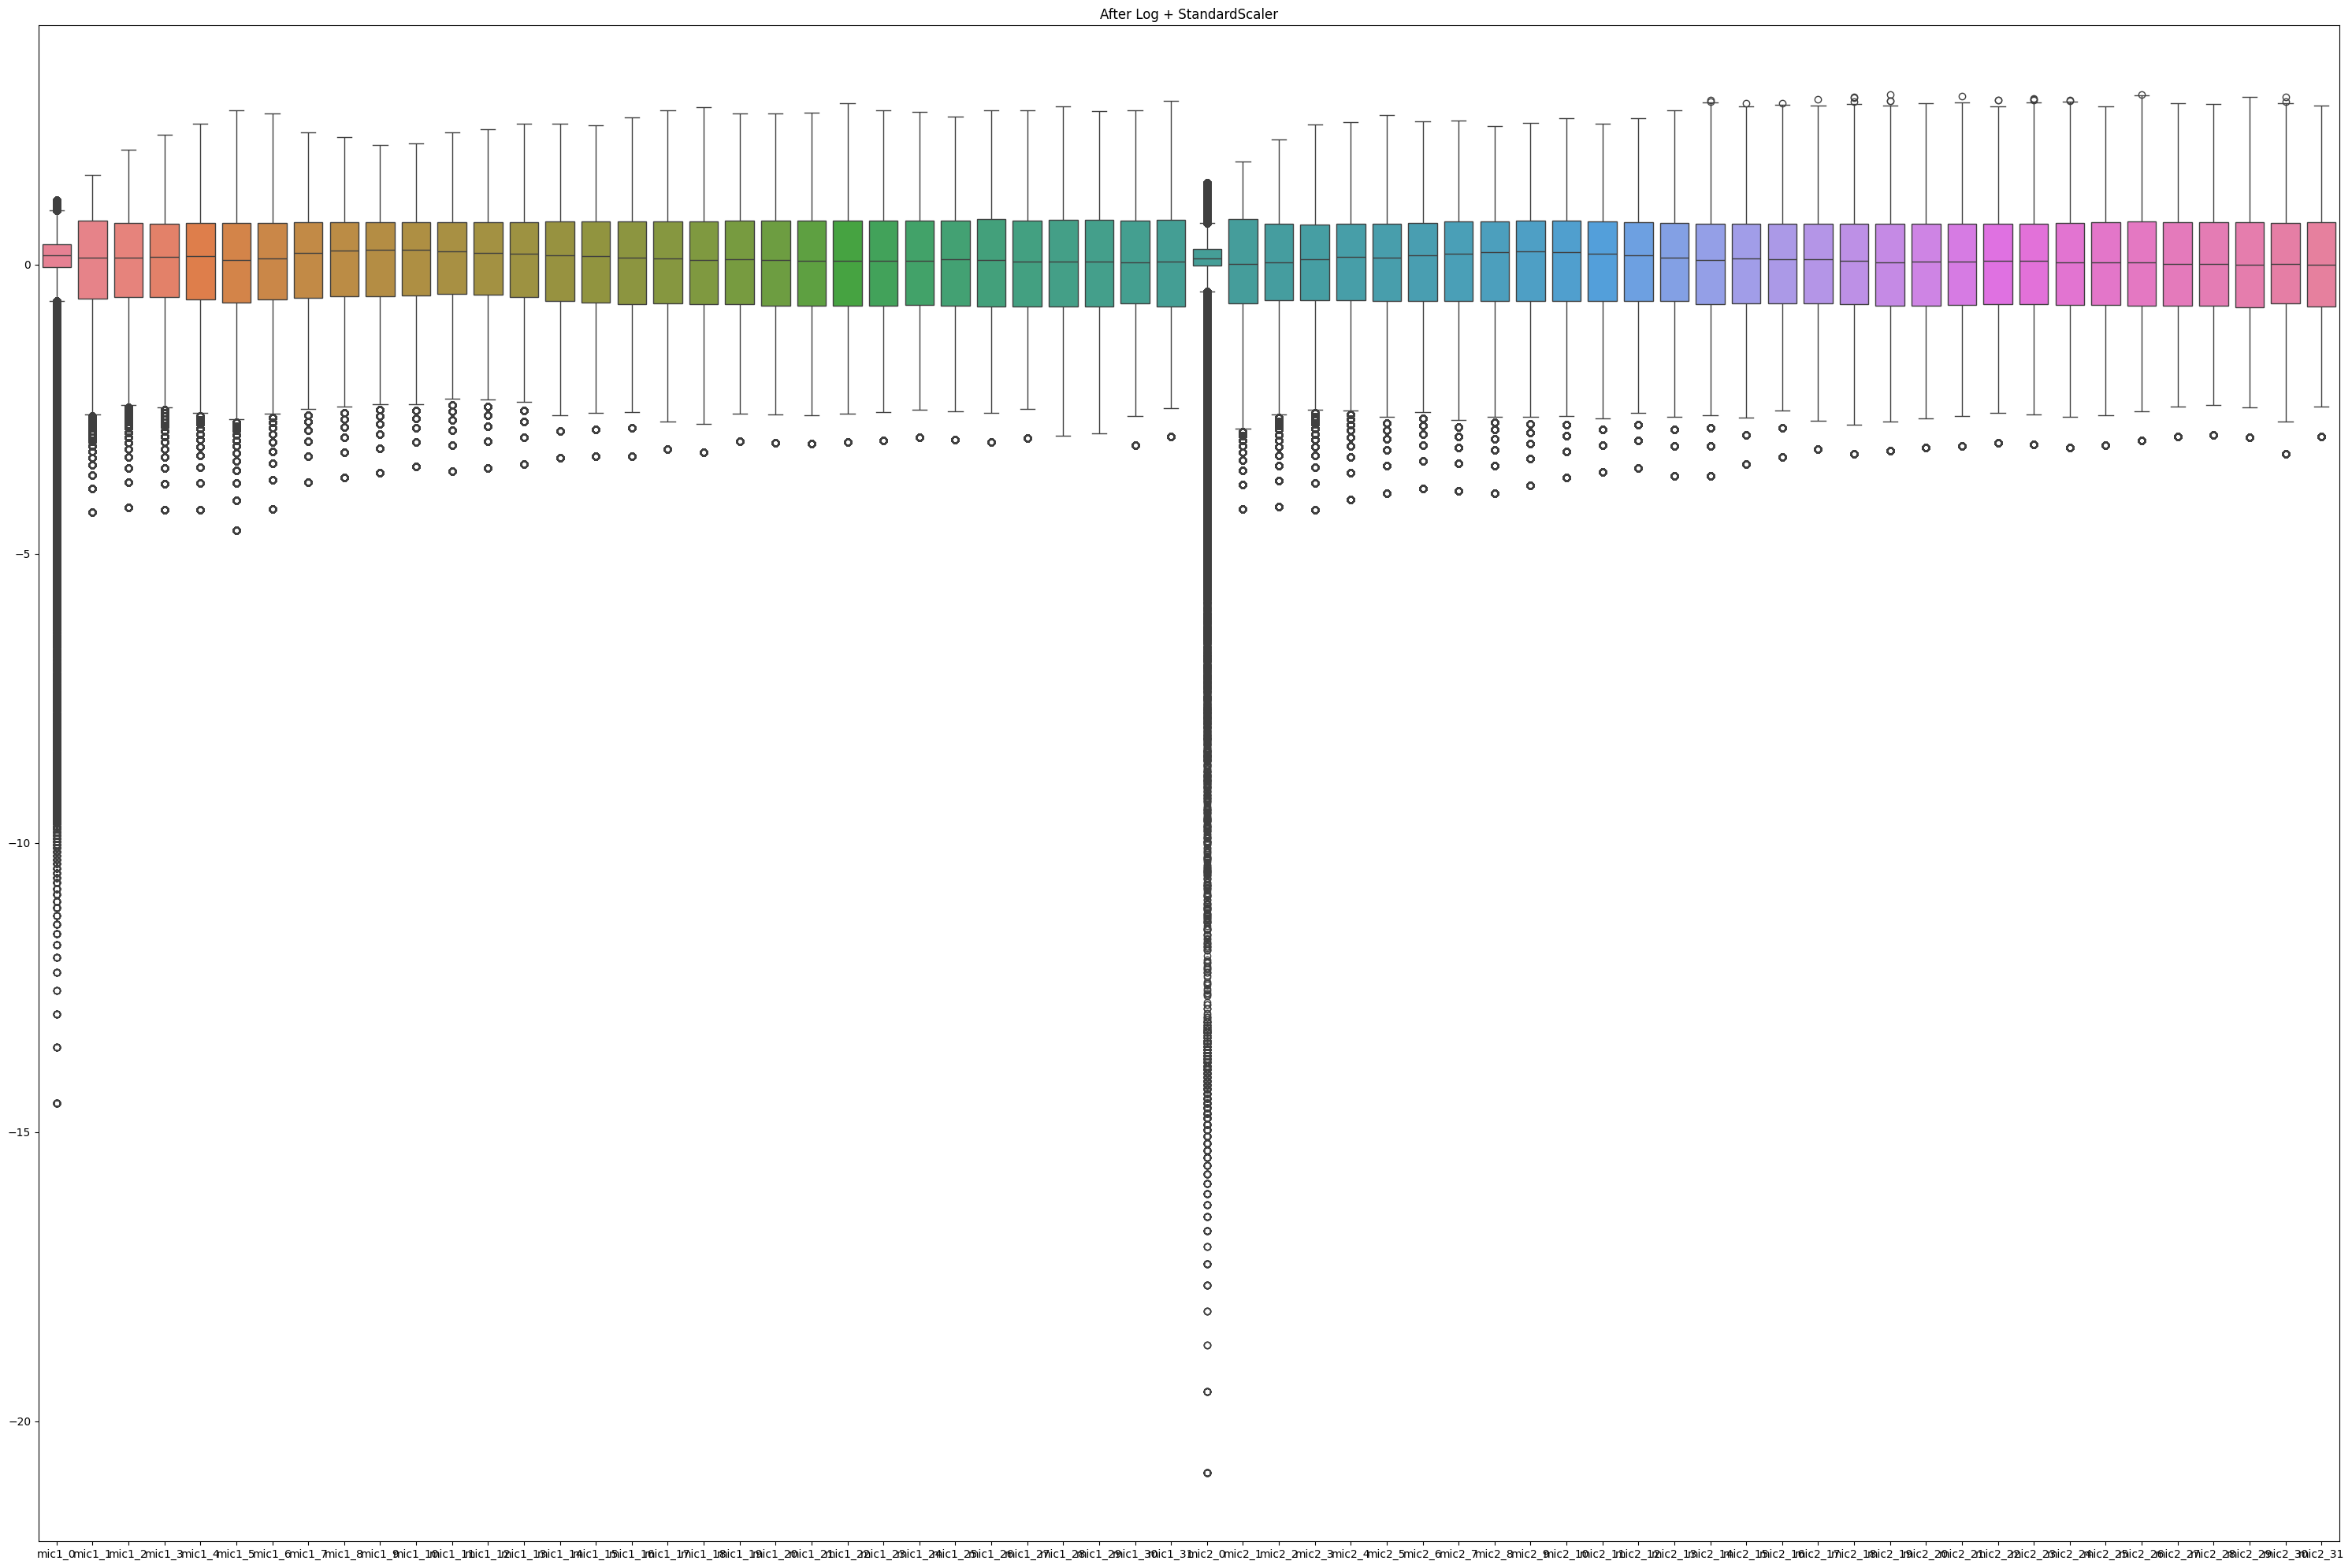

In [75]:
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_scaled_df)
plt.title("After Log + StandardScaler")
plt.tight_layout()
plt.show()

In [69]:
data.value_counts("label")

label
rubbing    190698
crumple    185639
idle        61137
Name: count, dtype: int64

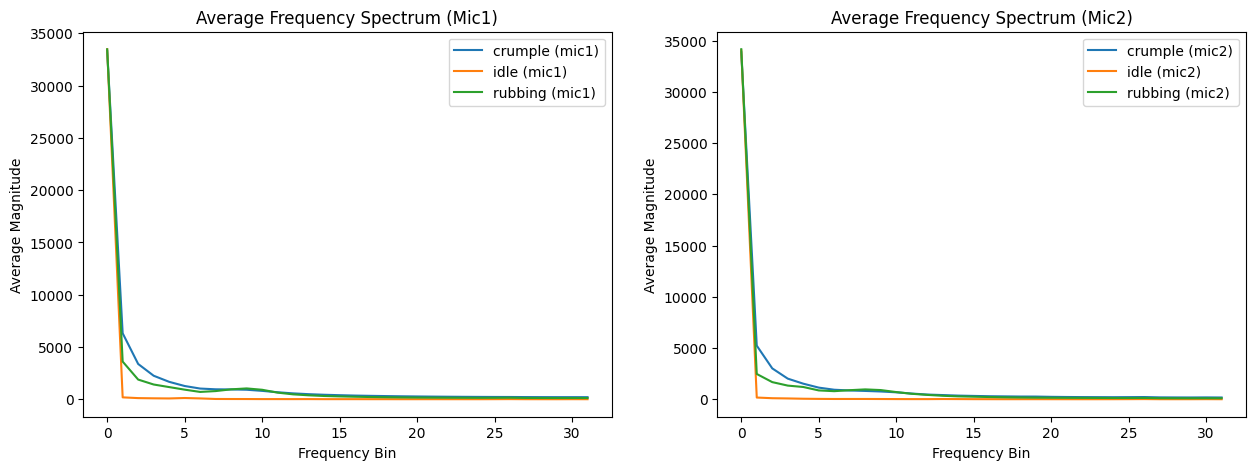

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for label, grp in data.groupby("label"):
    mic1_mean = grp.filter(like='mic1_').mean().values
    mic2_mean = grp.filter(like='mic2_').mean().values
    axes[0].plot(mic1_mean, label=f"{label} (mic1)")
    axes[1].plot(mic2_mean, label=f"{label} (mic2)")
axes[0].legend()
axes[1].legend()
axes[0].set_title("Average Frequency Spectrum (Mic1)")
axes[0].set_xlabel("Frequency Bin")
axes[0].set_ylabel("Average Magnitude")
axes[1].set_title("Average Frequency Spectrum (Mic2)")
axes[1].set_xlabel("Frequency Bin")
axes[1].set_ylabel("Average Magnitude")
plt.show()


In [ ]:
data.mean(a)

# UMAP

In [35]:
def visualize_umap_for_band(df, start, end, label, ax):
    mic1 = df.iloc[:, start:end]
    mic2 = df.iloc[:, start+32:end+32]  # mic2_0~31 오프셋 반영
    X = pd.concat([mic1, mic2], axis=1)
    y = df["label"]

    # 표준화
    X_scaled = StandardScaler().fit_transform(X)
    X_pca20 = PCA(n_components=20).fit_transform(X_scaled)

    # 샘플링 (최대 2000개)
    sample_size = 2000
    if len(X_pca20) > sample_size:
        idx = np.random.choice(len(X_pca20), sample_size, replace=False)
        X_sample = X_pca20[idx]
        y_sample = np.array(y)[idx]
    else:
        X_sample = X_pca20
        y_sample = np.array(y)

    # UMAP 적용
    umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
    X_umap = umap.fit_transform(X_sample)

    # Plot
    for lbl in np.unique(y_sample):
        mask = (y_sample == lbl)
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1], label=lbl, alpha=0.6)
    ax.set_title(f"{label}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")


/home/vscode/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/vscode/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/vscode/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


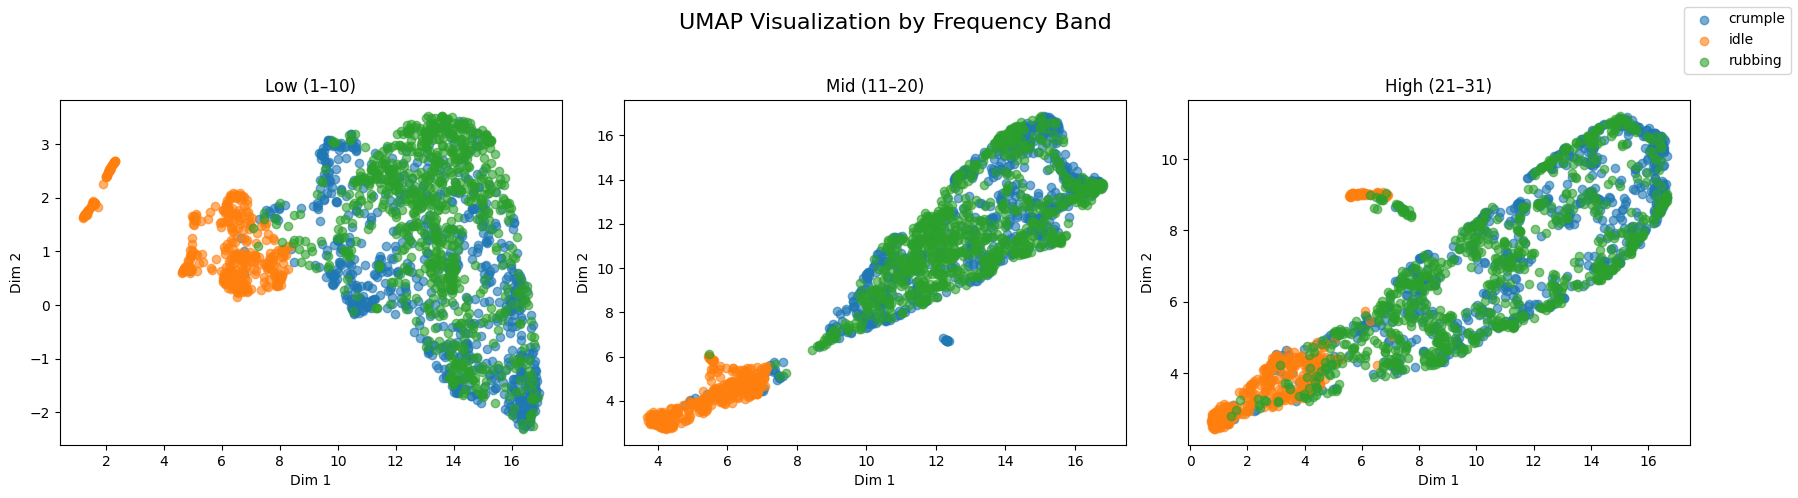

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, (start, end)) in zip(axes, bands.items()):
    visualize_umap_for_band(data, start, end, label, ax)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle("UMAP Visualization by Frequency Band", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()
